In [11]:
include("../sym_cliff.jl")
using PyPlot
using LaTeXStrings
using Profile

In [6]:
function XX_measurement!(state, posi1, posi2)
    M, N = size(state)
    uncommute_rows = [i for i in 1:M if !commute((X, X), (state[i, posi1], state[i, posi2]))]
    if isempty(uncommute_rows)
        return state
    end
    for row in uncommute_rows[2:end]
        state[row, :] .*= @view state[uncommute_rows[1], :]
    end
    row = uncommute_rows[1]
    state[row, :] .= II
    state[row, [posi1, posi2]] = Paulis[X, X]
    return state
end

db_all_up(N) = all_up(2N)
function depolarize!(state, i)
    N = div(size(state, 1), 2)
    ZZ_measurement!(state, i, N+i)
    XX_measurement!(state, i, N+i)
    return nothing
end

function thermal_entropy(state)
    N = div(size(state, 1), 2)
    return rk(state[:, 1:N]) - N
end

function db_rand_gate(state, i, j)
    N = div(size(state, 1), 2)
    cl = random_2clifford()
    cliff2_action(cl, state, i, j)
    cliff2_action(cl, state, i+N, j+N)
    return nothing
end

function adam_op!(state, i, j, channel, p, dilation)
    _, n = size(state)
    if rand() < dilation
        db_rand_gate(state, i, j)
    end
    if rand() < p && rand() < dilation
        channel(state, i)
    end
    if rand() < p && rand() < dilation
        channel(state, j)
    end
    return nothing
end

function bw_update!(state, channel, p, op, dilation, periodic=true)
    n = div(size(state, 1), 2)
    for i in 1 : (periodic ? n : n-1)
        j = i==n ? 1 : i+1
        op(state, i, j, channel, p, dilation)
    end
    return nothing
end

bw_update! (generic function with 2 methods)

In [7]:
n = 64
p_list = 0.1:0.1:0.8
dilation = 0.2
n_average = 1000
n_step = 60
channel = depolarize!
op = adam_op!
ees = zeros(length(p_list), n_step)

for i in 1:length(p_list)
    p = p_list[i]
    for _ in 1:n_average
        state = db_all_up(n)
        for k in 1:n_step
            ees[i, k] += thermal_entropy(state)
            bw_update!(state, channel, p, op, dilation)
        end
    end
end
ees ./= n_average

8×60 Array{Float64,2}:
 0.0   2.862   5.986   9.041  12.118  …  63.972  63.975  63.976  63.981
 0.0   5.717  11.431  16.903  22.225     63.999  63.999  64.0    64.0
 0.0   8.29   16.351  23.683  30.661     64.0    64.0    64.0    64.0
 0.0  10.982  20.952  29.782  37.208     64.0    64.0    64.0    64.0
 0.0  13.464  25.166  34.814  42.505     64.0    64.0    64.0    64.0
 0.0  15.928  28.914  39.191  46.751  …  64.0    64.0    64.0    64.0
 0.0  18.063  32.277  42.694  50.185     64.0    64.0    64.0    64.0
 0.0  20.528  35.524  45.966  53.036     64.0    64.0    64.0    64.0

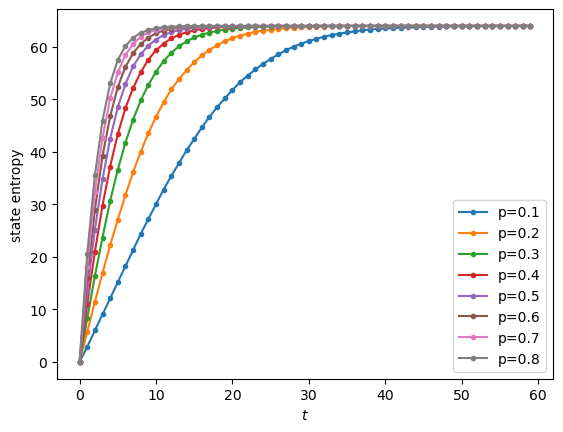

PyObject <matplotlib.legend.Legend object at 0x00000000020D7F10>

In [8]:
for i in 1:length(p_list)
    x = (0:n_step-1)
    plot(x, ees[i, :], ".-", label=string("p=", p_list[i]))
end
xlabel(L"$t$")
ylabel("state entropy")
legend()

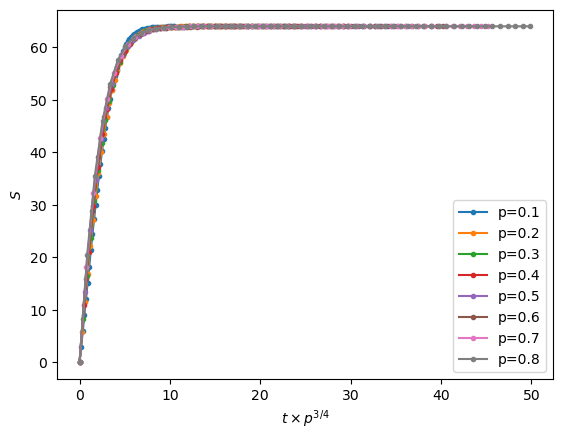

PyObject <matplotlib.legend.Legend object at 0x00000000025C15B0>

In [9]:
nv = 0.75
for i in 1:length(p_list)
    x = (0:n_step-1)
    plot(x .* p_list[i].^nv, ees[i, :], ".-", label=string("p=", p_list[i]))
end
xlabel(L"$t \times p^{3/4}$")
ylabel(L"$S$")
legend()

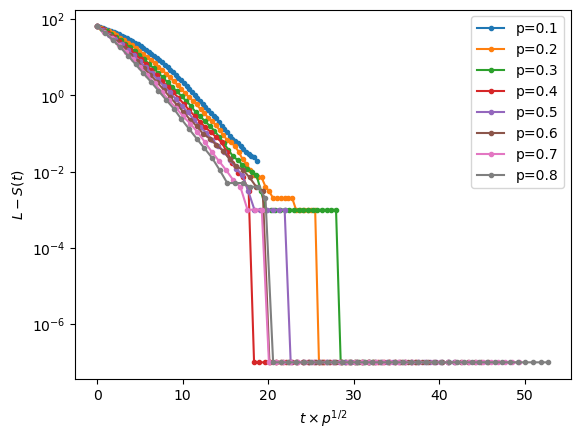

PyObject <matplotlib.legend.Legend object at 0x0000000052F59430>

In [10]:
eps = 1e-7
for i in 1:length(p_list)
    x = 0:n_step-1
    p = p_list[i]
    plot(x .* p .^ 0.5, n .- ees[i, :] .+ eps, ".-", label=string("p=", p_list[i]))
end
xlabel(L"$t \times p^{1/2}$")
ylabel(L"$L-S(t)$")
yscale("log")
legend()